In [38]:
import keras.callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import os
from utils import Config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [40]:
import pathlib
from utils import Config

In [41]:
config = Config()
data_dir = config.options["data_dir"]
train_dir = os.path.join(data_dir, "train")
valid_dir = os.path.join(data_dir, "valid")

In [56]:
def get_total_num_rows():
    config = Config()
    data_dir = config.options["data_dir"]
    img_paths = pathlib.Path(data_dir, 'MURA-v1.1/train_image_paths.csv')
    df = pd.read_csv(img_paths)
    return df.shape[0]

In [210]:
def get_ds(type:str = 'train'):
    config = Config()
    data_dir = config.options["data_dir"]
    if type == 'valid':
        img_paths = pathlib.Path(data_dir, 'MURA-v1.1/valid_image_paths.csv')
    else:
        img_paths = pathlib.Path(data_dir, 'MURA-v1.1/train_image_paths.csv')


    path_types = [tf.string]
    img_ds = tf.data.experimental.CsvDataset(str(img_paths), path_types)
    dir_label_types = [tf.string, tf.int32]

    def process_path(img_path):
        label = tf.strings.split(img_path, os.sep)[-2]
        label = tf.strings.split(label, '_')[-1]
        if label == b'positive':
            label = 1
        else:
            label = 0
        
        image = tf.io.read_file(data_dir+'/'+img_path)
        image = tf.io.decode_png(image, channels=3)
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize(image, [128, 128])
        
        # condition = tf.equal(image.shape[-1], 3)    
        # image = tf.cond(condition, lambda: tf.image.rgb_to_grayscale(image), lambda: image)
        return image, label

    labeled_ds = img_ds.map(process_path)
    return labeled_ds

In [211]:
get_ds()

<_MapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [218]:
def show(image, label):
  plt.figure()
  plt.imshow(image)
  plt.title(label)
  plt.axis('off')

(128, 128, 3)
(128, 128, 3)


2024-04-22 10:36:26.110798: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


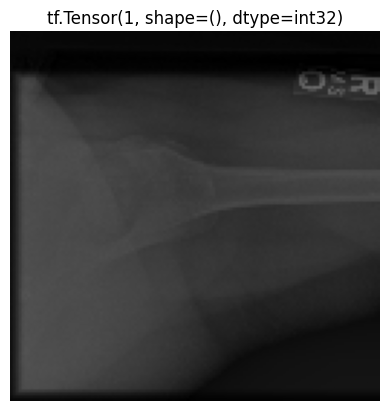

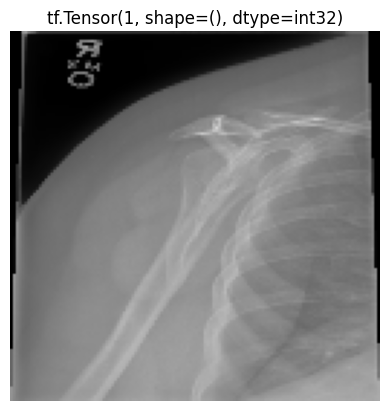

In [225]:
for img, label in get_ds().take(2):
    print(img.shape)
    show(img, label)

## Rotates images

In [239]:
import scipy.ndimage as ndimage

@tf.py_function(Tout=tf.float32)
def random_rotate_image(image):
  image = ndimage.rotate(image, np.random.uniform(-30, 30), reshape=False)
  return image
    
def tf_random_rotate_image(image, label):
  im_shape = image.shape
  rotated_image = random_rotate_image(image)
  # Ensure pixel values are within [0, 1] range
  rotated_image = tf.clip_by_value(rotated_image, 0.0, 1.0)  
  rotated_image.set_shape(im_shape)
  return rotated_image, label

In [240]:
train_ds = get_ds()
train_ds = train_ds.map(tf_random_rotate_image)

In [236]:
TOTAL_SAMPLE = get_total_num_rows()
EPOCHS = 100
BATCH_SIZE = 54
STEPS_PER_EPOCH = int(TOTAL_SAMPLE / BATCH_SIZE)

## Makes a model

In [237]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

In [243]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation="tanh", input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(32, (3, 3), activation="tanh"),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation="tanh"),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="tanh"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(
    loss="binary_crossentropy",
    # optimizer="adam",
    optimizer=get_optimizer(),
    metrics=["accuracy",
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [244]:
model_path = "muras_frac_detect_model.keras"
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_path, save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [245]:
train_bat_ds = train_ds.repeat(None).shuffle(buffer_size=30).batch(BATCH_SIZE)

## Fitting the model

In [247]:
history = model.fit(
    train_bat_ds,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=get_ds('valid').repeat(None).batch(BATCH_SIZE),
    validation_steps=20,
    callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/100
681/681 ━━━━━━━━━━━━━━━━━━━━ 155s 224ms/step - accuracy: 0.7245 - loss: 0.8964 - precision: 0.7024 - recall: 0.7887 - val_accuracy: 0.4815 - val_loss: 1.7176 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
681/681 ━━━━━━━━━━━━━━━━━━━━ 152s 224ms/step - accuracy: 0.6229 - loss: 0.8870 - precision: 0.6600 - recall: 0.5854 - val_accuracy: 0.5435 - val_loss: 1.5035 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
681/681 ━━━━━━━━━━━━━━━━━━━━ 152s 224ms/step - accuracy: 0.6283 - loss: 0.8766 - precision: 0.6621 - recall: 0.5856 - val_accuracy: 0.5185 - val_loss: 1.5764 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
681/681 ━━━━━━━━━━━━━━━━━━━━ 152s 224ms/step - accuracy: 0.6273 - loss: 0.8684 - precision: 0.6572 - recall: 0.5806 - val_accuracy: 0.4843 - val_loss: 1.6794 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/100
681/681 ━━━━━━━━━━━━━━━━━━━━ 153s 224ms/step - accuracy: 0.6311 - loss: 0.8609 - precision: 0.65

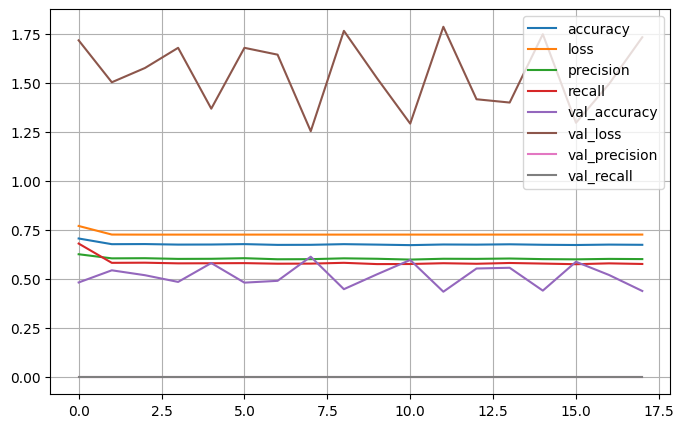

In [248]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()